# Coursera Data Science Capstone Project

## Introduction / Business Problem

The core question is: What is the best way to find the nearest hospitals in neighborhoods in New York City that are most impacted with COVID-19 cases?

Between March - May 2020, NYC saw the most number of positive cases with COVID-19. This project is for healthcare workers and residents of NYC to learn about the hospitals in their neighborhoods. And also to learn about the neighborhoods are were most impacted by the pandemic. 

## Data section

Data used to solve the problem include:
1. Data from Foursquare using the API to get hospitals data in the vicinity
2. Dataset that contains the five boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood
3. Counts and rates of confirmed cases, by NYC borough of residence

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
import io
import requests
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import geopy

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         393 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

Creating a dataset that contains the 5 boroughs and the neighborhoods that in each borough as well as the the latitude and logitude coordinates of each neighborhood from the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


### Step 1: Setting up data - exploring NYC neighborhood data set

In [3]:
#loading data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    

In [4]:
#to see the data
#newyork_data

In [5]:
neighborhoods_data = newyork_data['features']

#transforming this data into a pandas dataframe

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
#filling the dataframe with data

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
neighborhoods.shape

(306, 4)

In [8]:
#getting latitude and longitude of NYC we use geocoder and we need to define a user_agent called ny_explorer

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Step 2: Exploring NYC COVID-19 data set

In [ ]:
#importing raw data from the dataset in github

In [10]:
url = 'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/data-by-modzcta.csv'
df_covid = pd.read_csv(url, error_bad_lines=False)
df_covid.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,381,1616.94,23563.03,22,93.37,11.50,3312
1,10002,Chinatown/Lower East Side,Manhattan,1080,1407.07,76755.41,152,198.03,16.13,6697
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,460,854.99,53801.62,34,63.20,8.84,5204
3,10004,Financial District,Manhattan,32,876.57,3650.61,1,27.39,9.38,341
4,10005,Financial District,Manhattan,64,762.26,8396.11,2,23.82,8.50,753


In [11]:
df_covid.shape

(177, 10)

## Step 3:Finding the top 5 neighborhoods in NYC affected by COVID-19

In [12]:
#Arraning the values in decreasing order of number of COVID-19 cases
df_covid_highcases = df_covid.sort_values(by='COVID_CASE_COUNT', ascending=False)
df_covid_highcases = df_covid_highcases.head()
df_covid_highcases = df_covid_highcases.reset_index()
df_covid_highcases

,index,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,139,11368,Corona/North Corona,Queens,4670,4184.81,111594.10,407,364.71,28.34,16477
1,72,10467,Allerton/Norwood/Pelham Parkway/Williamsbridge,Bronx,3470,3443.01,100784.05,301,298.66,26.09,13298
2,143,11373,Elmhurst,Queens,3301,3554.21,92875.81,293,315.48,24.82,13302
3,106,11219,Borough Park,Brooklyn,3107,3345.97,92858.07,219,235.84,19.62,15835
4,74,10469,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,3057,4275.03,71508.25,332,464.28,26.28,11631


In [13]:
print ("The top 5 neighborhoods in NYC with the highest number of COVID_19 cases are: \n")

for ind in df_covid_highcases.index: 
    print(df_covid_highcases['NEIGHBORHOOD_NAME'][ind], df_covid_highcases['COVID_CASE_COUNT'][ind])
    



The top 5 neighborhoods in NYC with the highest number of COVID_19 cases are: 

Corona/North Corona 4670
Allerton/Norwood/Pelham Parkway/Williamsbridge 3470
Elmhurst 3301
Borough Park 3107
Allerton/Baychester/Pelham Gardens/Williamsbridge 3057


## Step 4: Finding hostipals close to the neighborhoods with highest number of cases

In [14]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'YORSP0ZDNXJBVWGABSVIC0KJQE4PYETGJML2MWFGIOTQ5QCB' # your Foursquare ID
CLIENT_SECRET = 'S2OZJZFCOSSE1ZPAVCTVFRD43DMN1C3ACD5G1AV2TZPWCQRL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YORSP0ZDNXJBVWGABSVIC0KJQE4PYETGJML2MWFGIOTQ5QCB
CLIENT_SECRET:S2OZJZFCOSSE1ZPAVCTVFRD43DMN1C3ACD5G1AV2TZPWCQRL


In [15]:
#Getting the latitue and logitudes of the top 5 neighborhoods with the highest number of cases
!pip install pgeocode
import pgeocode

nomi = pgeocode.Nominatim('us')
df=nomi.query_postal_code(["11368","10467","11373","11219","10469"])
df

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,11368,US,Corona,New York,NY,Queens,81.0,NaN,NaN,40.7453,-73.8611,4.0
1,10467,US,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8737,-73.8712,4.0
2,11373,US,Elmhurst,New York,NY,Queens,81.0,NaN,NaN,40.7351,-73.8776,4.0
3,11219,US,Brooklyn,New York,NY,Kings,47.0,NaN,NaN,40.6336,-73.9960,4.0
4,10469,US,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8702,-73.8495,4.0


In [16]:
#dropping unwanted columns in the dataframe
df_new=df

df_new

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,11368,US,Corona,New York,NY,Queens,81.0,NaN,NaN,40.7453,-73.8611,4.0
1,10467,US,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8737,-73.8712,4.0
2,11373,US,Elmhurst,New York,NY,Queens,81.0,NaN,NaN,40.7351,-73.8776,4.0
3,11219,US,Brooklyn,New York,NY,Kings,47.0,NaN,NaN,40.6336,-73.9960,4.0
4,10469,US,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8702,-73.8495,4.0


In [17]:
#Merging the two dataframes
df_covid_highcases=pd.concat([df_covid_highcases, df_new],axis=1)
df_covid_highcases

,index,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,139,11368,Corona/North Corona,Queens,4670,4184.81,111594.10,407,364.71,28.34,16477,11368,US,Corona,New York,NY,Queens,81.0,NaN,NaN,40.7453,-73.8611,4.0
1,72,10467,Allerton/Norwood/Pelham Parkway/Williamsbridge,Bronx,3470,3443.01,100784.05,301,298.66,26.09,13298,10467,US,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8737,-73.8712,4.0
2,143,11373,Elmhurst,Queens,3301,3554.21,92875.81,293,315.48,24.82,13302,11373,US,Elmhurst,New York,NY,Queens,81.0,NaN,NaN,40.7351,-73.8776,4.0
3,106,11219,Borough Park,Brooklyn,3107,3345.97,92858.07,219,235.84,19.62,15835,11219,US,Brooklyn,New York,NY,Kings,47.0,NaN,NaN,40.6336,-73.9960,4.0
4,74,10469,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,3057,4275.03,71508.25,332,464.28,26.28,11631,10469,US,Bronx,New York,NY,Bronx,5.0,NaN,NaN,40.8702,-73.8495,4.0


In [18]:
# Plotting the top 5 COVID-19 affected neighborhoods - marked in yellow
incidents = folium.map.FeatureGroup()


# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(df_covid_highcases.latitude, df_covid_highcases.longitude):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
map_newyork.add_child(incidents)


In [19]:
#Creating a Choloropleth map of most affected neighborhoods

df_covid['MODIFIED_ZCTA']=df_covid['MODIFIED_ZCTA'].astype(str)

map_newyork.choropleth(geo_data="https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson",
             data=df_covid, 
             columns=['MODIFIED_ZCTA', 'COVID_CASE_COUNT'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.postalCode', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='CORONA VIRUS CASES')

map_newyork

In [20]:
neighborhood_latitude = 40.7453
neighborhood_longitude = -73.8611
LIMIT = 1
radius = 500

url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d104941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url 

'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d104941735&client_id=YORSP0ZDNXJBVWGABSVIC0KJQE4PYETGJML2MWFGIOTQ5QCB&client_secret=S2OZJZFCOSSE1ZPAVCTVFRD43DMN1C3ACD5G1AV2TZPWCQRL&v=20180605&ll=40.7453,-73.8611&radius=500&limit=1'

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef160501e152c001b51145a'},
 'response': {'venues': [{'id': '4c65ca7f9cb82d7f66ea8ed2',
    'name': 'National Pediatric Center',
    'location': {'address': '102-11 Roosevelt Ave',
     'crossStreet': 'National St',
     'lat': 40.750004,
     'lng': -73.863655,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.750004,
       'lng': -73.863655}],
     'distance': 566,
     'postalCode': '11368',
     'cc': 'US',
     'city': 'Flushing',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['102-11 Roosevelt Ave (National St)',
      'Flushing, NY 11368',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d177941735',
      'name': "Doctor's Office",
      'pluralName': "Doctor's Offices",
      'shortName': "Doctor's Office",
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_doctorsoffice_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1592

## Step 5: Exploring data trends in Corona Virus

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [23]:
print(df_covid.dtypes)

MODIFIED_ZCTA         object
NEIGHBORHOOD_NAME     object
BOROUGH_GROUP         object
COVID_CASE_COUNT       int64
COVID_CASE_RATE      float64
POP_DENOMINATOR      float64
COVID_DEATH_COUNT      int64
COVID_DEATH_RATE     float64
PERCENT_POSITIVE     float64
TOTAL_COVID_TESTS      int64
dtype: object


In [24]:
df_covid.corr()

,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
COVID_CASE_COUNT,1.000000,0.573672,0.848789,0.914224,0.515973,0.567648,0.919686
COVID_CASE_RATE,0.573672,1.000000,0.156858,0.486529,0.711996,0.866726,0.325595
POP_DENOMINATOR,0.848789,0.156858,1.000000,0.808298,0.260958,0.242854,0.944004
COVID_DEATH_COUNT,0.914224,0.486529,0.808298,1.000000,0.680703,0.471155,0.861047
COVID_DEATH_RATE,0.515973,0.711996,0.260958,0.680703,1.000000,0.596517,0.375664
PERCENT_POSITIVE,0.567648,0.866726,0.242854,0.471155,0.596517,1.000000,0.282604
TOTAL_COVID_TESTS,0.919686,0.325595,0.944004,0.861047,0.375664,0.282604,1.000000


In [25]:
df_covid[['COVID_CASE_COUNT','COVID_DEATH_COUNT','POP_DENOMINATOR','TOTAL_COVID_TESTS']].corr()

,COVID_CASE_COUNT,COVID_DEATH_COUNT,POP_DENOMINATOR,TOTAL_COVID_TESTS
COVID_CASE_COUNT,1.000000,0.914224,0.848789,0.919686
COVID_DEATH_COUNT,0.914224,1.000000,0.808298,0.861047
POP_DENOMINATOR,0.848789,0.808298,1.000000,0.944004
TOTAL_COVID_TESTS,0.919686,0.861047,0.944004,1.000000


(0, 4919.164720463202)

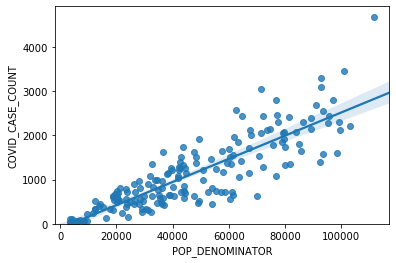

In [26]:
sns.regplot(x="POP_DENOMINATOR", y="COVID_CASE_COUNT", data=df_covid)
plt.ylim(0,)

As the population goes up, the case count goes up: this indicates a positive direct correlation between these two variables.

(0, 4922.292308675093)

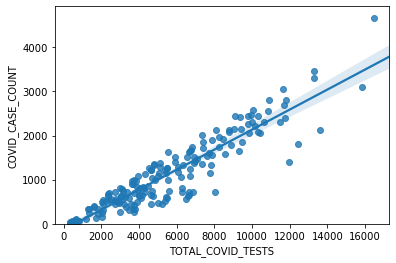

In [29]:
sns.regplot(x="TOTAL_COVID_TESTS", y="COVID_CASE_COUNT", data=df_covid)
plt.ylim(0,)

As the number of tests conducted goes up, the case count goes up: this indicates a positive direct correlation between these two variables.

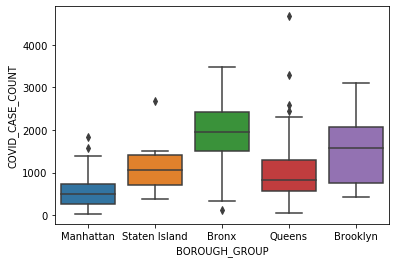

In [27]:
sns.boxplot(x="BOROUGH_GROUP", y="COVID_CASE_COUNT", data=df_covid)

In [28]:
df_covid.describe()

,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,1143.841808,2334.584972,47425.734237,99.062147,193.697853,19.321525,5632.525424
std,815.848010,889.644976,26411.133886,79.608928,105.051343,5.974027,3309.594714
min,26.000000,582.200000,3457.770000,0.000000,0.000000,7.280000,341.000000
25%,534.000000,1648.780000,26614.420000,38.000000,121.560000,15.310000,3135.000000
50%,901.000000,2403.630000,43030.430000,78.000000,182.630000,20.420000,5038.000000
75%,1636.000000,2959.530000,67089.290000,148.000000,241.610000,24.290000,7731.000000
max,4670.000000,4486.840000,111594.100000,407.000000,660.580000,29.380000,16477.000000


## Step 6: Finding correlation, causation, and develpoing a best-fit model

In [29]:
from scipy import stats

### Developing a linear model with population and # of COVID-19 cases

In [30]:
pearson_coef, p_value = stats.pearsonr(df_covid['POP_DENOMINATOR'],df_covid['COVID_CASE_COUNT'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.8487893891256116  with a P-value of P = 2.6070725052325563e-50


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline 

In [32]:
lm = LinearRegression()
lm
X = df_covid[['POP_DENOMINATOR']]
Y = df_covid['COVID_CASE_COUNT']
lm.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
Yhat=lm.predict(X)
Yhat[0:5] 

array([ 518.17687886, 1912.84725351, 1311.01347771,   -3.91410977,
        120.50988222])

In [34]:
lm.intercept_

-99.63078227976689

In [35]:
lm.coef_

array([0.02621936])

(0, 4918.438629909125)

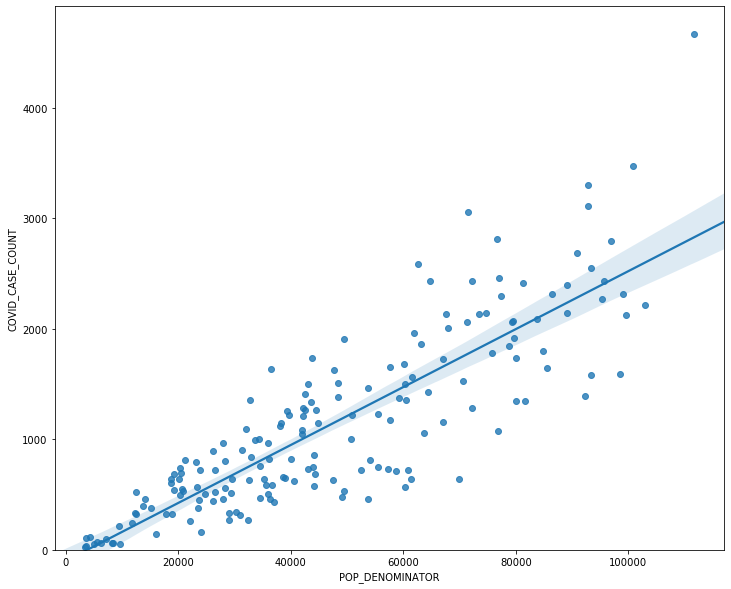

In [37]:
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x="POP_DENOMINATOR", y="COVID_CASE_COUNT", data=df_covid)
plt.ylim(0,)

In [50]:
#highway_mpg_fit
lm.fit(X, Y)
# Find the R^2
print('The R-square is: ', lm.score(X, Y))

The R-square is:  0.8458221583960741


In [53]:
from sklearn.metrics import mean_squared_error

In [55]:
mse = mean_squared_error(df_covid['COVID_CASE_COUNT'], Yhat)
print('The mean square error of price and predicted value is: ', mse)

The mean square error of price and predicted value is:  102042.21559822497


### Developing a linear model with # of tests conducted and # of COVID-19 cases

In [65]:
pearson_coef, p_value = stats.pearsonr(df_covid['TOTAL_COVID_TESTS'],df_covid['COVID_CASE_COUNT'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.9196859020318155  with a P-value of P = 5.856479134321609e-73


In [69]:
lm1 = LinearRegression()
lm1
X1 = df_covid[['TOTAL_COVID_TESTS']]
Y1 = df_covid['COVID_CASE_COUNT']
lm1.fit(X1,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [70]:
Yhat=lm1.predict(X)
Yhat[0:5] 

array([ 617.75149601, 1385.17067081, 1046.6900717 ,  -55.80902639,
         37.59620256])

In [71]:
lm1.intercept_

-133.1177231749432

In [72]:
lm1.coef_

array([0.22671172])

(0, 4920.995822943192)

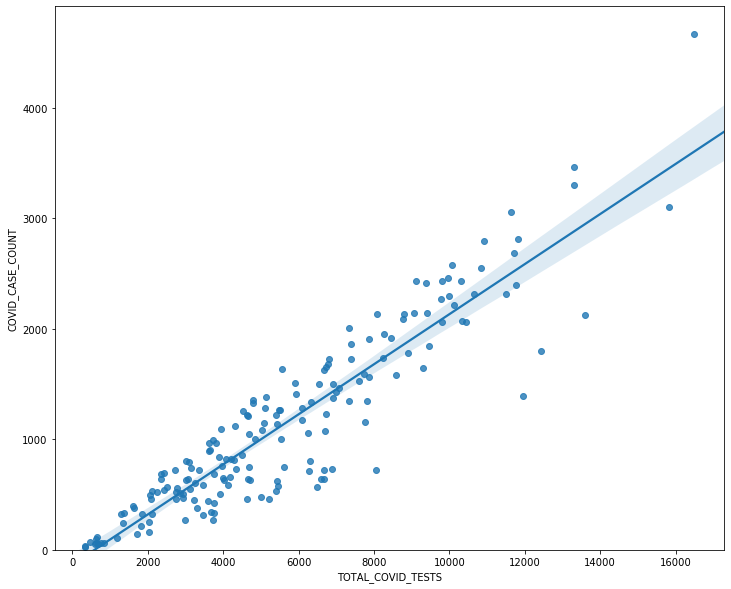

In [73]:
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x="TOTAL_COVID_TESTS", y="COVID_CASE_COUNT", data=df_covid)
plt.ylim(0,)

In [74]:
#highway_mpg_fit
lm1.fit(X1, Y1)
# Find the R^2
print('The R-square is: ', lm1.score(X1, Y1))

The R-square is:  0.8458221583960741


In [75]:
from sklearn.metrics import mean_squared_error

In [76]:
mse = mean_squared_error(df_covid['COVID_CASE_COUNT'], Yhat)
print('The mean square error of price and predicted value is: ', mse)

The mean square error of price and predicted value is:  102042.21559822497


### Developing a multiple linear model with population, # of tests conducted and # of COVID-19 cases

In [45]:
Z = df_covid[['TOTAL_COVID_TESTS', 'POP_DENOMINATOR']]

In [78]:
lm.fit(Z, df_covid['COVID_CASE_COUNT'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [79]:
lm.intercept_

-105.62761449705499

In [80]:
lm.coef_

array([ 0.26817845, -0.00550445])

In [48]:
Y_hat = lm.predict(Z)

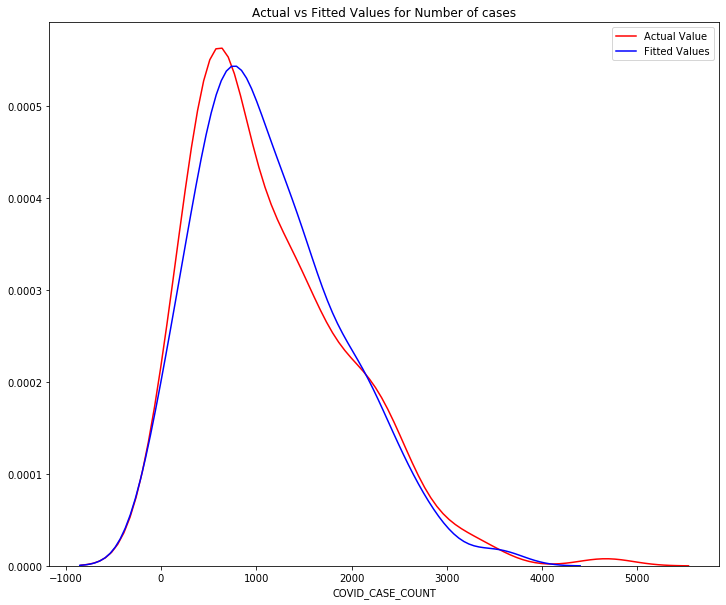

In [49]:
plt.figure(figsize=(width, height))


ax1 = sns.distplot(df_covid['COVID_CASE_COUNT'], hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Number of cases')


plt.show()
plt.close()

## Step 7: Conclusion

Population and number of tests conducted were two big causes for the high COVID-19 cases reported